# Real-Time Animation [2017 Fix]

In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

Populating the interactive namespace from numpy and matplotlib


In [2]:
def findAdjacent(coordinates, coordinate, cluster):
    distances = sqrt(sum((coordinates-coordinate)**2,1))
    newCoordIndices = np.where(logical_and(distances<1.5, distances >0))[0]
    
    for newCoordIndex in newCoordIndices:
        if newCoordIndex not in cluster:
            cluster.append(newCoordIndex)
            findAdjacent(coordinates, coordinates[newCoordIndex, :], cluster)

In [3]:
def findClusters(coordinates):
    allIndices = np.arange(len(coordinates))
    clusters = []

    while len(allIndices) > 0:

        cluster = [allIndices[0]]
        findAdjacent(coordinates, coordinates[allIndices[0],:], cluster)
        allIndices = np.setdiff1d(allIndices, np.array((cluster)))
        clusters.append(cluster)
        
    return clusters

In [4]:
def countFingers(clusters, minFingerSize = 15, fingerCutoff = 0.5):
    sizes = []
    for cluster in clusters:
        sizes.append(len(cluster))

    sizes = np.array(sizes)
    
    if len(sizes) > 0:
        if np.max(sizes) > minFingerSize:
            fingerCluster = np.argmax(sizes)
            numFingers = sum(sizes>fingerCutoff*sizes[fingerCluster])
        else:
            numFingers = 0
    else:
        numFingers = 0
        
    return numFingers

In [18]:
def extractFeaturesXOnly(imageDict, whichImage = 'image1bit', dist = 4):
    img = imageDict[whichImage]

    featuresList = []
    for i in arange(imageDict['boxEdges'][2], imageDict['boxEdges'][3]):
        for j in arange(imageDict['boxEdges'][0], imageDict['boxEdges'][1]):
            f = img[i-dist:i+dist+1, j-dist:j+dist+1]

            fVec = f.ravel()
            featuresList.append(fVec)

    features = np.vstack((featuresList))
    
    return features

In [19]:
clusterColors = 1e3*np.array(([[255, 0, 255], 
                           [0, 255, 255],
                           [255, 255, 0],
                           [0, 0, 255],
                           [0, 255, 0],
                           [0, 0, 255]]))

## Import Image Stream

In [20]:
import cPickle as pickle

pickleFileName = 'video' + '.pickle'
pickleFile = open(pickleFileName, 'rb')
images = pickle.load(pickleFile)
pickleFile.close()

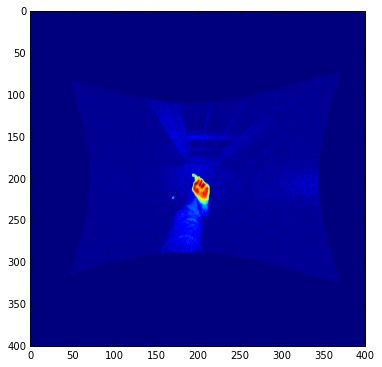

In [21]:
fig = figure(0, (6,6))
imshow(images[20])

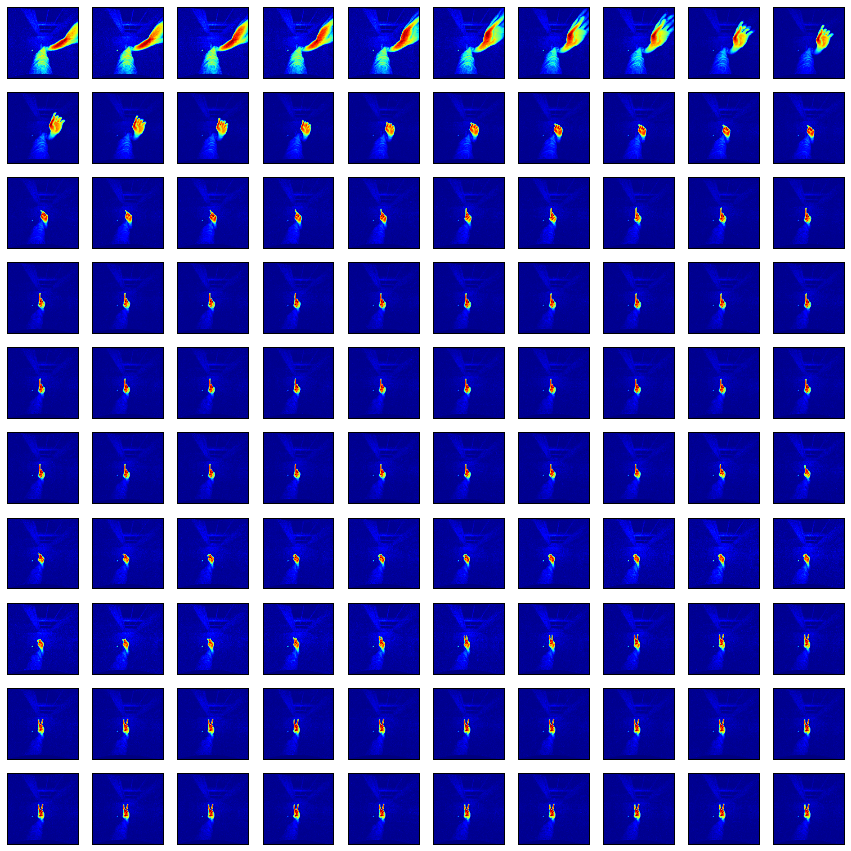

In [22]:
fig = figure(0, (15,15))
for i in range(100):
    ax = fig.add_subplot(10,10,i+1)
    imshow(images[i][100:300, 100:300])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

## Processing Support Functions

In [23]:
#Custom function to identify unique rows in a 2d numpy arrray.
def uniqueRows(a):
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    _, idx = np.unique(b, return_index=True)

    aUnique = a[idx].astype('int')
    
    return aUnique


def addBoundingBox(imageDict, boxBorder = 8):
    
    if imageDict['handPoints'].shape[0]>10:
        minY = min(imageDict['handPoints'][:,0])
        minX = min(imageDict['handPoints'][:,1])
        maxY = max(imageDict['handPoints'][:,0])
        maxX = max(imageDict['handPoints'][:,1])

        xRange = arange(minX-boxBorder, maxX+1+boxBorder)
        yRange = arange(minY-boxBorder, maxY+1+boxBorder)

        top = np.vstack(([(minY-boxBorder)*np.ones(len(xRange)), xRange])).T
        bottom = np.vstack(([(maxY+boxBorder)*np.ones(len(xRange)), xRange])).T
        left = np.vstack(([yRange, (minX-boxBorder)*np.ones(len(yRange))])).T
        right = np.vstack(([yRange, (maxX+boxBorder)*np.ones(len(yRange))])).T

        box = np.vstack(([top, bottom, left, right]))

        imageDict['handEdges'] = [minX, maxX, minY, maxY]
        imageDict['boxEdges'] = [minX-boxBorder, maxX+boxBorder, minY-boxBorder, maxY+boxBorder]
        boxHeight = ((maxY+boxBorder)- (minY-boxBorder))
        boxWidth = ((maxX+boxBorder)- (minX-boxBorder))

        imageDict['boxHeight'] = boxHeight
        imageDict['boxWidth'] = boxWidth
        imageDict['numPointsInBox'] = boxHeight*boxWidth

        imageDict['box'] = box

In [24]:
def expandToCoverHand(img):
    searchVector = np.array(([0, 1],
                         [0, -1],
                         [1, 1],
                         [1, 0],
                         [1, -1],
                         [-1, 1],
                         [-1, 0],
                         [-1, -1],))
    
    spatialMean = np.array(([np.argmax(sum(img,1)), np.argmax(sum(img,0))]))
    allPoints  = np.array(([[np.argmax(sum(img,1)), np.argmax(sum(img,0))]]))
    
    if img[spatialMean[0], spatialMean[1]] > 180:    
        allPoints = expand(img, spatialMean, allPoints, searchVector)
    
    return allPoints

## Process "Video Stream" Into List of Dicts

In [25]:
import time

startTime = time.time()

boxBorder = 8
flip = False

imageList = []

for i in range(len(images)):
    image = images[i]
    imageDict = {}
    if flip:
        imageDict['image'] = flipud(image)
    else: 
        imageDict['image'] = image
        
    #imageDict['handPoints'] = expandToCoverHand(img = imageDict['image'], threshold = 0.5, numIterations = 30)
    #imageDict['handPoints'] = expandToCoverHand(imageDict['image'])
    
    #Hacky-hack.
    c = np.where(imageDict['image'] >100)
    imageDict['handPoints'] = np.hstack((c[0].reshape(len(c[0]), 1), c[1].reshape(len(c[0]), 1)))
    
    addBoundingBox(imageDict, boxBorder = boxBorder)
    imageList.append(imageDict)
    #print str(i) + ' images done, time elapsed = ' + str(time.time()-startTime)

print 'Time Elapsed = ' + str(time.time()-startTime)

Time Elapsed = 0.885542154312


/Users/stephenwelch/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


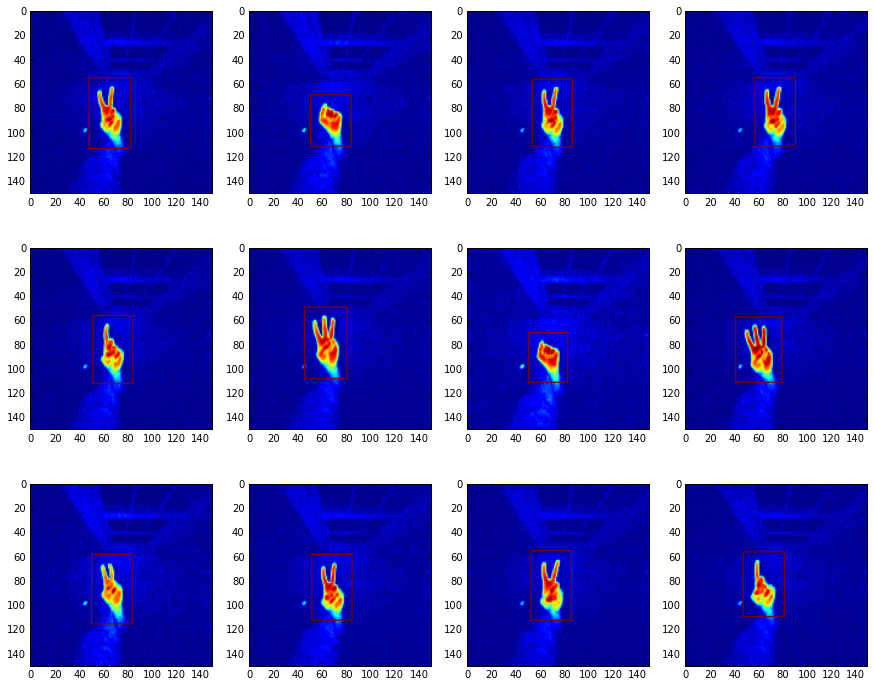

In [26]:
#Show random subsample:
indices = arange(len(imageList))
shuffle(indices)

fig = figure(0, (15, 12))
for i in range(12):
    imageDict = imageList[indices[i]]
    image = imageDict['image'].copy()
    handMask = np.zeros((400,400))

    maxVal = np.max(image)
    
    if 'box' in imageDict.keys():
        for point in imageDict['box']:
            handMask[point[0], point[1]] = maxVal 
        
        image[handMask==maxVal] = maxVal

    subplot(3,4,i+1)
    imshow(image[125:275, 125:275])

These bounding boxes are not working, I need to look into this first thing in the morning.

## Extract Features, Count Fingers

In [37]:
# Import scikit learn model from opening animation notebook
import cPickle as pickle
pickleName = 'feb2tree.p'
pickleFile = open(pickleName, 'rb')
clf = pickle.load(pickleFile)
pickleFile.close()

In [41]:
for imageDict in imageList:
    
    if 'box' in imageDict.keys():
        imageDict['image1bit'] = imageDict['image']>42
        testX = extractFeaturesXOnly(imageDict, whichImage = 'image1bit', dist = 4)
        yhat = clf.predict(testX)
        
        yhatImage = yhat.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
        imageDict['yhatImage'] = yhatImage

        c = np.where(imageDict['yhatImage'] == 1)
        imageDict['coordinates'] = np.hstack((c[0].reshape(len(c[0]), 1), c[1].reshape(len(c[0]), 1)))

        imageDict['clusters'] = findClusters(imageDict['coordinates'])
        imageDict['numFingers'] = countFingers(imageDict['clusters'], minFingerSize = 15, fingerCutoff = 0.4)

In [42]:
clusterColors = np.array(([[1, 0, 1], 
                           [0, 1, 1],
                           [1, 1, 0],
                           [0, 0, 1],
                           [0, 1, 0],
                           [0, 0, 1]]))

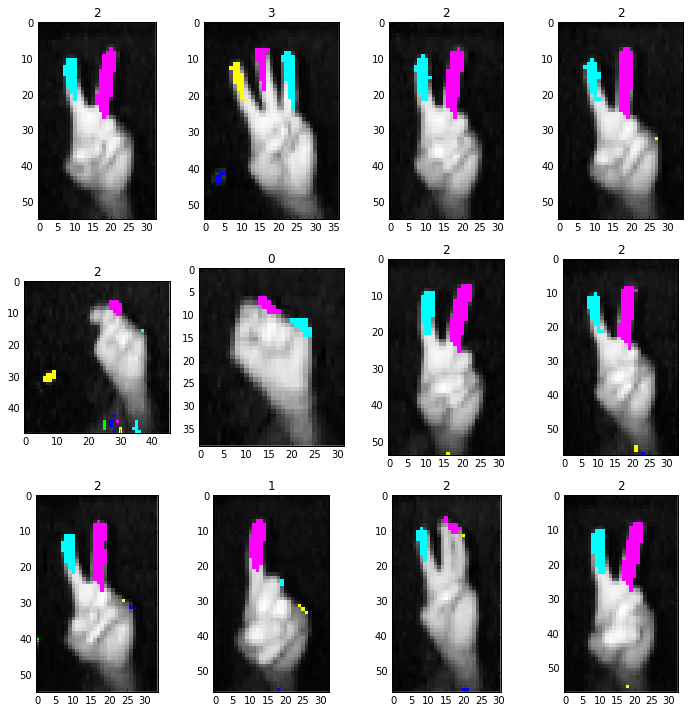

In [46]:
#Show random subsample:
indices = arange(len(imageList))
shuffle(indices)
fig = figure(0, (12,12))

for i in range(12):
    fig.add_subplot(3,4,i+1)
    
    imageDict = imageList[indices[i]]

    if 'box' in imageDict.keys():
        coordinates = imageDict['coordinates']

        clusters = imageDict['clusters']
        numFingers = imageDict['numFingers']

        #Make Grayscale image within bounding box
        im = np.zeros((imageDict['boxHeight'], imageDict['boxWidth'], 3))
        maxVal = np.max(imageDict['image'])

        im[:,:,0] = (1./maxVal)*imageDict['image'][imageDict['boxEdges'][2]:imageDict['boxEdges'][3], \
                                           imageDict['boxEdges'][0]:imageDict['boxEdges'][1]]
        im[:,:,1] = (1./maxVal)*imageDict['image'][imageDict['boxEdges'][2]:imageDict['boxEdges'][3], \
                                           imageDict['boxEdges'][0]:imageDict['boxEdges'][1]]
        im[:,:,2] = (1./maxVal)*imageDict['image'][imageDict['boxEdges'][2]:imageDict['boxEdges'][3], \
                                           imageDict['boxEdges'][0]:imageDict['boxEdges'][1]]

        #Paint with matches:
        for i, cluster in enumerate(clusters):
            for index in cluster:
                im[coordinates[index, 0], coordinates[index, 1], 0] = clusterColors[mod(i, len(clusterColors)), 0]
                im[coordinates[index, 0], coordinates[index, 1], 1] = clusterColors[mod(i, len(clusterColors)), 1]
                im[coordinates[index, 0], coordinates[index, 1], 2] = clusterColors[mod(i, len(clusterColors)), 2]

        imshow(im, interpolation = 'none')
        title(numFingers)
    
    else:
        imshow(imageDict['image'])

## Hmm - it seems to be counting some 2's as 1s. 

- Is this a result of the fact that I'm using a different tree?

In [47]:
darkGrey = "#808080"
import pydot 
from IPython.display import Image  

In [48]:
def addChildren(graph, parent, labels = ['1', '2'], message = '""', styles = ['rounded', 'rounded', '""', '""'], \
               colors = ["#808080", "#808080"]):
    
    left = pydot.Node(labels[0], label = message, style = styles[0], color = colors[0], \
                                              shape = 'box', fontname = 'helvetica')

    right = pydot.Node(labels[1], label = message, style = styles[1], color = colors[1], \
                                              shape = 'box', fontname = 'helvetica')
    graph.add_node(left)
    graph.add_node(right)

    graph.add_edge(pydot.Edge(parent, left, style = styles[2], color = colors[0]))
    graph.add_edge(pydot.Edge(parent, right, style = styles[3], color = colors[1]))
    
    return left, right

In [49]:
def addTerminalNodes(graph, parent, labels = ['1', '2'], message = '""', styles = ['""', '""', '""', '""'], \
               colors = ["#808080", "#808080"]):
    
    left = pydot.Node(labels[0], label = message, style = styles[0], color = colors[0], \
                                              shape = 'box', fontname = 'helvetica', width = '0.5', height = '0.5')

    right = pydot.Node(labels[1], label = message, style = styles[1], color = colors[1], \
                                              shape = 'box', fontname = 'helvetica', width = '0.5', height = '0.5')
    graph.add_node(left)
    graph.add_node(right)

    graph.add_edge(pydot.Edge(parent, left, style = styles[2], color = colors[0]))
    graph.add_edge(pydot.Edge(parent, right, style = styles[3], color = colors[1]))
    
    return left, right

In [50]:
def computeStyle(value, terminal = False):
    if terminal:
        if value:
            styles = ['""', 'bold', '""', 'bold']
            nodeColors = [darkGrey, 'black']
        else:
            styles = ['bold', '""', 'bold', '""']
            nodeColors = ['black', darkGrey]
  
    else:  
        if value:
            styles = ['rounded', 'rounded, bold', '""', 'bold']
            nodeColors = [darkGrey, 'black']

        else:
            styles = ['rounded, bold', 'rounded', 'bold', '""']
            nodeColors = ['black', darkGrey]
        
    return styles, nodeColors

## Make all black bold tree for tree building animation

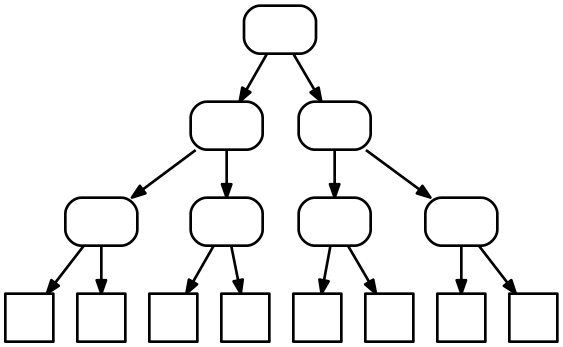

In [51]:
graph = pydot.Dot(graph_type='digraph')
message = '""'

root = pydot.Node('0', label = message, style = 'rounded, bold', \
                                              shape = 'box', color = 'black', fontname = 'helvetica')
graph.add_node(root)

styles = ['rounded, bold', 'rounded, bold', 'bold', 'bold']
nodeColors = ['black', 'black']
L, R = addChildren(graph, root, ['1', '2'], styles = styles, colors = nodeColors)

LL, LR = addChildren(graph, L, ['3', '4'], styles = styles, colors = nodeColors)
RL, RR = addChildren(graph, R, ['5', '6'], styles = styles, colors = nodeColors)

styles = ['bold',  'bold', 'bold', 'bold']
LLL, LLR = addTerminalNodes(graph, LL, ['7', '8'], styles = styles, colors = nodeColors)
LRL, LRR = addTerminalNodes(graph, LR, ['9', '10'], styles = styles, colors = nodeColors)
RLL, RLR = addTerminalNodes(graph, RL, ['11', '12'], styles = styles, colors = nodeColors)
RRL, RRR = addTerminalNodes(graph, RR, ['13', '14'], styles = styles, colors = nodeColors)

Image(graph.create_png())

In [52]:
def highlightTree(featureValues):
    graph = pydot.Dot(graph_type='digraph')
    root = pydot.Node('0', label = '""', style = 'rounded, bold', \
                                                  shape = 'box', color = 'black', fontname = 'helvetica')
    
    graph.add_node(root)
    styles, nodeColors = computeStyle(featureValues[0])
    L, R = addChildren(graph, root, ['1', '2'], styles = styles, colors = nodeColors)

    if featureValues[0]:
        styles, nodeColors = computeStyle(featureValues[2])
        LL, LR = addChildren(graph, L, ['3', '4'])
        RL, RR = addChildren(graph, R, ['5', '6'], styles = styles, colors = nodeColors)
        if featureValues[2]:
            styles, nodeColors = computeStyle(featureValues[6], terminal = True)
            LLL, LLR = addTerminalNodes(graph, LL, ['7', '8'])
            LRL, LRR = addTerminalNodes(graph, LR, ['9', '10'])
            RLL, RLR = addTerminalNodes(graph, RL, ['11', '12'])
            RRL, RRR = addTerminalNodes(graph, RR, ['13', '14'], styles = styles, colors = nodeColors)

        else:
            styles, nodeColors = computeStyle(featureValues[5], terminal = True)
            LLL, LLR = addTerminalNodes(graph, LL, ['7', '8'])
            LRL, LRR = addTerminalNodes(graph, LR, ['9', '10'])
            RLL, RLR = addTerminalNodes(graph, RL, ['11', '12'], styles = styles, colors = nodeColors)
            RRL, RRR = addTerminalNodes(graph, RR, ['13', '14'])

    else:
        styles, nodeColors = computeStyle(featureValues[1])
        LL, LR = addChildren(graph, L, ['3', '4'], styles = styles, colors = nodeColors)
        RL, RR = addChildren(graph, R, ['5', '6'])

        if featureValues[1]:
            styles, nodeColors = computeStyle(featureValues[4], terminal = True)
            LLL, LLR = addTerminalNodes(graph, LL, ['7', '8'])
            LRL, LRR = addTerminalNodes(graph, LR, ['9', '10'], styles = styles, colors = nodeColors)
            RLL, RLR = addTerminalNodes(graph, RL, ['11', '12'])
            RRL, RRR = addTerminalNodes(graph, RR, ['13', '14'])

        else:
            styles, nodeColors = computeStyle(featureValues[3], terminal = True)
            LLL, LLR = addTerminalNodes(graph, LL, ['7', '8'], styles = styles, colors = nodeColors)
            LRL, LRR = addTerminalNodes(graph, LR, ['9', '10'])
            RLL, RLR = addTerminalNodes(graph, RL, ['11', '12'])
            RRL, RRR = addTerminalNodes(graph, RR, ['13', '14'])

    return graph
    

In [54]:
panelsToRender = 900

In [56]:
leftEdge = 185
rightEdge = 194
topEdge = 190
bottomEdge = 199

left = np.vstack((np.arange(topEdge,bottomEdge), leftEdge*np.ones(9))).T
right = np.vstack((np.arange(topEdge,bottomEdge), rightEdge*np.ones(9))).T
top = np.vstack((topEdge*np.ones(9), np.arange(leftEdge,rightEdge))).T
bottom = np.vstack((bottomEdge*np.ones(9), np.arange(leftEdge,rightEdge))).T

centralBox = np.vstack(([left, right, top, bottom]))

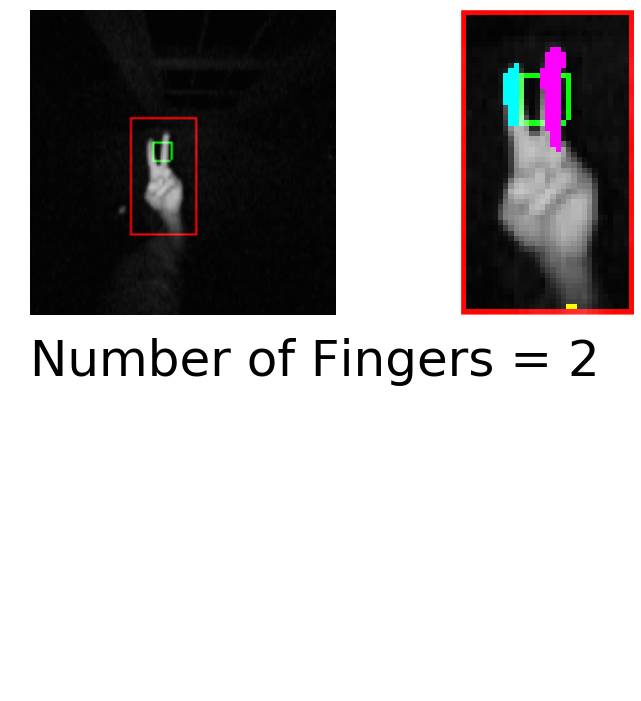

In [57]:
imCount = 0

for i in range(panelsToRender):
    imageDict = imageList[i]
    plt.clf()
    fig = figure(0, (12,12))

    ax = fig.add_subplot(2, 2, 1)
    #make grayscale image:
    wholeImage = np.zeros((400, 400, 3))
    wholeImage[:,:,0] = (1./255)*imageDict['image']
    wholeImage[:,:,1] = (1./255)*imageDict['image']
    wholeImage[:,:,2] = (1./255)*imageDict['image']

    for point in imageDict['box']:
        wholeImage[int(point[0]), int(point[1]), 0] = 1
        
    #Add central box:
    for point in centralBox:
        wholeImage[int(point[0]), int(point[1]), 1] = 1

    ax.imshow(wholeImage[125:275, 125:275], 'Greys')
    ax.axis('off');

    ax = fig.add_subplot(2, 2, 2)
    coordinates = imageDict['coordinates']

    clusters = imageDict['clusters']
    numFingers = imageDict['numFingers']

    #Make Grayscale image within bounding box
    im = wholeImage.copy()[imageDict['boxEdges'][2]:imageDict['boxEdges'][3]+1, \
                                       imageDict['boxEdges'][0]:imageDict['boxEdges'][1]+1, :]

    #Paint with matches:
    for i, cluster in enumerate(clusters):
        for index in cluster:
            im[coordinates[index, 0], coordinates[index, 1], :] = clusterColors[mod(i, len(clusterColors)), :]

    imshow(im, interpolation = 'none')
    ax.axis('off');

    ax3 = fig.add_subplot(2,2,3)
    ax3.axes.text(0, 1, 'Number of Fingers = ' + str(imageDict['numFingers']), fontsize = 50, color = 'k')
    ax3.axis('off');

    savefig('realTimeTwo/panels/panel' + str(imCount) + '.png')

    imCount = imCount + 1 

## 9x9 Grids

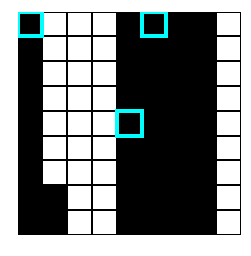

In [62]:
def convertIndexToCoordinates(index):
    row = 8-int(floor(index/9))
    column = mod(index, 9)
    
    return column, row

imCount = 0
nodeFeatures = [40, 49, 0, 39, 53, 53, 5]

for i in range(panelsToRender):
    imageDict = imageList[i]

    centralSquare = imageDict['image1bit'][topEdge:bottomEdge, leftEdge:rightEdge]
    featureValues = centralSquare.ravel()

    #Figure out which features to highlight:
    featuresToHighlight = [40]
    if featureValues[40]:
        featuresToHighlight.append(0)
        if featureValues[0]:
            featuresToHighlight.append(5)           
        else:
            featuresToHighlight.append(53)
    else:
        featuresToHighlight.append(49)
        if featureValues[49]:
            featuresToHighlight.append(53)         
        else:
            featuresToHighlight.append(39)

    plt.clf()
    fig = figure(0, (4,4))
    ax = fig.add_subplot(111)
    ax.pcolor(flipud(centralSquare), cmap = 'Greys', linewidth = 1, color = 'k')
    ax.axis('off');

    ##Add indicator square:
    for feature in featuresToHighlight:
        boxX,boxY = convertIndexToCoordinates(feature)
        ax.add_patch(patches.Rectangle((boxX,boxY), 1, 1, fill = False, edgecolor = [0, 1,1], \
                                  linewidth = 4, zorder= 10))

    savefig('realTimeTwo/grids/grid' + str(imCount) + '.png')

    imCount = imCount + 1 

## Trees

In [61]:
#Hardcoded left to right from example above:
nodeFeatures = [40, 49, 0, 39, 53, 53, 5]

imCount = 0

for i in range(panelsToRender):
    imageDict = imageList[i]

    centralSquare = imageDict['image1bit'][topEdge:bottomEdge, leftEdge:rightEdge]

    featureValues = centralSquare.ravel()[nodeFeatures]

    graph = highlightTree(featureValues)
    graph.write_png('realTImeTwo/trees/tree' + str(imCount) + '.png')
    
    imCount = imCount +1